# Jina AI: Image similarity search example

In [2]:
from jina import Document, DocumentArray, Flow
import os
import sys

# Change workspace to main repository
os.chdir(os.path.join(sys.path[0], '..'))

from executors import *

## Executors test

### Index data

In [2]:

# Generate index data
from jina.logging.logger import JinaLogger

def _index_data_generator(dir, num_docs=None):
    
    logger = JinaLogger('index_generator')

    img_extensions = ['.png', '.jpg']
    txt_extensions = ['.txt']

    files = os.listdir(dir) 

    for i, file in enumerate(files):
        
        file_name, file_extension = os.path.splitext(file)   

        if file_extension in img_extensions:
            modality = 'image'
        elif file_extension in txt_extensions:
            modality = 'text'
        else: 
            logger.warning(f'Not supported extension: {file}')
            continue

        file_path = os.path.join(dir, file)
        doc = Document(id = i, 
                        uri = file_path,
                        modality = modality,
                        tags = {
                            'name': file_name,
                            'path': file_path,
                            'extension': file_extension,
                            'index': i,
                            }
                        )

        yield doc

        if num_docs and (i + 1) >= num_docs:
            break
index_path = 'data/toy_data'

In [3]:
# ImageUriLoader
image_loader = ImageUriLoader()
index_data = image_loader.index_directory(docs=_index_data_generator(index_path))

# ImageProcessor
image_processor = ImageProcessor()
index_data_ = image_processor.process_img(index_data)

# TfModelEncoder
encoder = TfModelEncoder()
encoder.encode(index_data_)


2021-10-29 12:51:52.216514: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-29 12:51:52.216554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BumbleBee): /proc/driver/nvidia/version does not exist
2021-10-29 12:51:52.216685: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-29 12:51:53.531397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [4]:
# Get embeddings
index_embeddings, _ = index_data_.get_attributes_with_docs('embedding')

### Query data

In [5]:
# Query data
example_image = 'data/toy_data/example.jpg'

image_loader = ImageUriLoader()
query_data = image_loader.get_url(parameters={'img_path': example_image})

image_processor = ImageProcessor()
query_data_ = image_processor.process_img(query_data)

encoder = TfModelEncoder()
encoder.encode(query_data_)

query_embeddings, _ = query_data_.get_attributes_with_docs('embedding')

 ImageUriLoader@12836[I]:Load query image file: data/toy_data/example.jpg


### Calculate similarity

In [6]:
import numpy as np

# Cosine similarity calculation function
def cosine_similarity(x,y):
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom

Image 1: data/toy_data/example.jpg
Image 2: data/toy_data/1.jpg
Similarity score: 0.9633817076683044


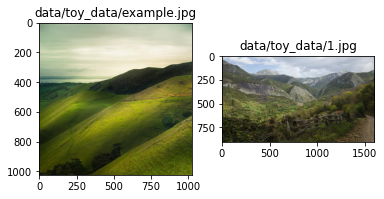

In [17]:
# Compare two images
query_i = 0
index_i = 1

doc_query_img = query_data_[query_i]
doc_index_img = index_data_[index_i]

# Similarity
print(f"Image 1: {doc_query_img.uri}")
print(f"Image 2: {doc_index_img.uri}")
print(f"Similarity score: {cosine_similarity(query_embeddings[query_i], index_embeddings[index_i])}")

# Plot two images
import matplotlib.pyplot as plt
from PIL import Image

#read the image
query_im=Image.open(doc_query_img.uri)
index_im=Image.open(doc_index_img.uri)

#show image
f, ax = plt.subplots(1, 2)
ax[0].set_title(doc_query_img.tags__path)
ax[1].set_title(doc_index_img.tags__path)
ax[0].imshow(query_im)
ax[1].imshow(index_im)
plt.show()

## Flow test

In [11]:
from jina import Flow
from app.config import *
config_env()

In [18]:
f_index = Flow().load_config('flows/index.yml')
f_index.plot('visualization/index.png')


In [19]:

f_query = Flow().load_config('flows/query.yml')
f_query.plot('visualization/query.png')